In [1]:
import numpy as np
import importlib
import fncs
import matplotlib.pyplot as plt
import random
import pandas as pd

importlib.reload(fncs)

<module 'fncs' from '/home/gathomp3/Deep_Learning/NNs/fncs.py'>

Helper Function

In [2]:
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# This function produces a summary of performance metrics including a confusion matrix
def summaryPerf(yTrain,yTrainHat,y,yHat):
    # Plotting confusion matrix for the non-training set:
    cm = metrics.confusion_matrix(y,yHat,normalize='true')
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=
                                  ['Walk Hard','Down Stairs','Up Stairs','Walk Soft'])
    disp.plot()

    # Displaying metrics for training and non-training sets
    print('Training:  Acc = {:4.3f}'.format(metrics.accuracy_score(yTrain,yTrainHat)))
    print('Non-Train: Acc = {:4.3f}'.format(metrics.accuracy_score(y,yHat)))
    print('Training:  BalAcc = {:4.3f}'.format(metrics.balanced_accuracy_score(yTrain,yTrainHat)))
    print('Non-Train: BalAcc = {:4.3f}'.format(metrics.balanced_accuracy_score(y,yHat)))

## Load and visualize distribution of classes to pick validation trials

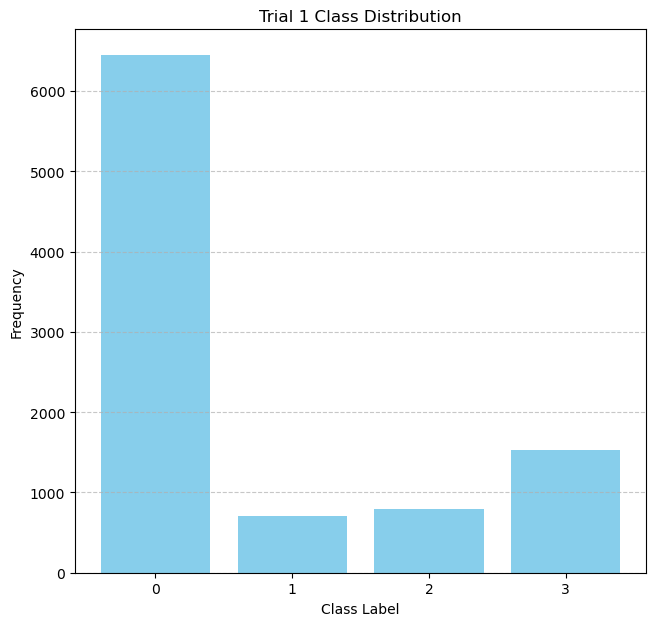

In [3]:
X_trial_path = "./GaitData/data/train/"

#trainIDs = list(set(np.array(range(29))+1))
trainIDs=[1]

def load_and_viz_data(path,trainIDs):
    
    # Matplot lib stuff
    fig, axs = plt.subplots(5, 6, figsize=(2*18, 2*15))
    axs = axs.flatten()
   
    Xts = []
    Xvs = []
    yts = []
    yvs = []
    for i, idx in enumerate(trainIDs):
        Xt, Xv, yt, yv = fncs.loadTrial(path, idx)
        Xts.append(Xt)
        Xvs.append(Xv)
        yts.append(yt)
        yvs.append(yv)

        unique_classes, class_counts = np.unique(yv, return_counts=True)
        
        axs[i].bar(unique_classes, class_counts, color='skyblue')
        axs[i].set_title(f'Trial {idx} Class Distribution')
        axs[i].set_xlabel('Class Label')
        axs[i].set_ylabel('Frequency')
        axs[i].set_xticks(unique_classes)
        axs[i].grid(axis='y', linestyle='--', alpha=0.7)

    # Want to visualize the distribution of training trials
    for i in range(len(trainIDs), len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()
    return Xts, Xvs, yts, yvs

Xts, Xvs, yts, yvs = load_and_viz_data(X_trial_path,trainIDs)


## Choosing Validation Trials [1, 8, 9, 20, 27] to get most heterogenous trials

## Defining Window Extraction Function (reusing some code from the previous notebook)

In [4]:
def extractWindow(xt,xv,winSz,timeStart,timeEnd,timeStep):
    tList = []
    windowList = []
    # Specifying the initial window for extracting features
    t0 = timeStart
    t1 = t0+winSz

    while(t1<=timeEnd):
        # Using the middle time of the window as a reference time
        tList.append((t0+t1)/2)

        # Extracting xWindow
        xWin = xv[(xt>=t0)*(xt<=t1),:]
        windowList.append(xWin)
        # Updating the window by shifting it by the step size
        t0 = t0+timeStep
        t1 = t0+winSz

    tList = np.array(tList)
    windowList = np.array(windowList)

    return tList, windowList

In [5]:
# Extract label takes mode over window range. This should be fine.
timeStep = 1
winSz = 3
time_start = 0
time_end = 60

# Temporary to test windowing function

Xt_train = Xts[0] 
Xv_train = Xvs[0]
yt_train = yts[0]
yv_train = yvs[0]

time_list_temp, window_list_temp = extractWindow(Xt_train, Xv_train, winSz, time_start, time_end, timeStep)


### Dims: 1D array of all mean window times

In [6]:
time_list_temp, time_list_temp.shape 

(array([ 1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 11.5,
        12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5, 22.5,
        23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5, 33.5,
        34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5, 44.5,
        45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5, 55.5,
        56.5, 57.5, 58.5]),
 (58,))

### Dims: Number of windows x samples per window x number of channels

In [7]:
window_list_temp.shape

(58, 121, 6)

#### Checking the extract label for y's

In [8]:
yt_temps, yv_temps = fncs.extractLabel(yt_train, yv_train, winSz, time_start, time_end, timeStep)

In [9]:
yt_temps.shape, yv_temps.shape

((58,), (58,))

In [10]:
time_list_temp

array([ 1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 11.5,
       12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5, 22.5,
       23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5, 33.5,
       34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5, 44.5,
       45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5, 55.5,
       56.5, 57.5, 58.5])

In [11]:
yt_temps

array([ 1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 11.5,
       12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5, 22.5,
       23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5, 33.5,
       34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5, 44.5,
       45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5, 55.5,
       56.5, 57.5, 58.5])

Looks good. Now we extract the windows from each trial and save to training and validation sets.

### Raw data to windowed data

Specify hyperparameters window size and step size

In [12]:
def loadWindows(dataFolder,winSz,timeStep,idList):
    for k,id in enumerate(idList):
        # Loading the raw data
        xt, xv, yt, yv = fncs.loadTrial(dataFolder,id=id)

        # Extracting the time window for which we have values for the measurements and the response
        timeStart = np.max((np.min(xt),np.min(yt)))
        timeEnd = np.min((np.max(xt),np.max(yt)))

        # Extracting the features
        x_times, x_windows = extractWindow(xt,xv,winSz,timeStart,timeEnd,timeStep)
        y_times, lab = fncs.extractLabel(yt,yv,winSz,timeStart,timeEnd,timeStep)

        # Storing the features
        if(k==0):
            window_list = x_windows
            labList = lab
            x_times_list = x_times
            y_times_list = y_times
        else:
            window_list = np.concatenate((window_list,x_windows),axis=0)
            labList = np.concatenate((labList,lab),axis=0)
            x_times_list = np.concatenate((x_times_list,x_times),axis=0)
            y_times_list = np.concatenate((y_times_list,y_times),axis=0)

    return window_list, labList, x_times_list, y_times_list

In [13]:
window_size = 3
time_step = 1

val_idxs = [1, 8, 9, 20, 27]
train_idxs = [i for i in range(1,30) if i not in val_idxs]

Xw_train, yw_train, xt_train, _ = loadWindows(X_trial_path,window_size,time_step,train_idxs)
Xw_val, yw_val, xt_val, _ = loadWindows(X_trial_path,window_size,time_step,val_idxs)

    


In [14]:
Xw_train.shape

(27942, 120, 6)

## Preprocessing

In [15]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


Define weights which to weight cross-entropy function based on class imbalances

In [16]:
# Weights for the loss function scaled by class
class_distribution = np.unique(yw_train, return_counts=True)[1]
scale_factor = 2
weights = (scale_factor*(1/class_distribution)/np.linalg.norm(1/class_distribution)).tolist()

In [17]:
weights

[0.08417742129136543,
 1.566503142158926,
 1.1674006299696538,
 0.41971161110624955]

## Trying synthetic data

In [18]:
Xw_train.shape

(27942, 120, 6)

In [19]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

# fit predictor and target
temp_shape = Xw_train.shape
Xw_train = Xw_train.reshape(Xw_train.shape[0],-1)

Xw_train, yw_train = ros.fit_resample(Xw_train, yw_train)

Xw_train = Xw_train.reshape([-1,120,6])

In [69]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.functional import normalize

def transform(X, y=None):
    X = torch.from_numpy(X).float()
    X = normalize(X, dim = 2)
    X = X.permute(0, 2, 1)
    X = X.to(device)
    
    if y is not None:
        y = torch.from_numpy(y).long()
        y = y.to(device)
        return X, y 
    return X


def create_dataloader(X, y, batch_size, device, shuffle=False):
    X,y = transform(X,y)

    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader, dataset

batch_size = 200
train_dataloader, train_dataset = create_dataloader(Xw_train, yw_train, batch_size, device, shuffle=True)
val_dataloader, val_dataset = create_dataloader(Xw_val, yw_val, batch_size, device, shuffle=False)


## Simple CNN

In [21]:
simple_cnn = nn.Sequential(
    nn.Conv1d(6, 12, kernel_size=3, padding="same"),
    nn.ReLU(),
    nn.Conv1d(12, 24, kernel_size=3, padding="same"),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2, stride=2),
    nn.Dropout(p=0.5) ,

    nn.Flatten(),
    nn.Linear(24*60, 200),
    nn.ReLU(),
    nn.Linear(200, 4),
)

In [22]:
simple_cnn =  simple_cnn.to(device)

# criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.75,1,1,1]).to(device))
optimizer = optim.SGD(simple_cnn.parameters(), lr=0.001, momentum=0.999, weight_decay=0.01)
'''
epochs = 100
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = simple_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
'''

"\nepochs = 100\nfor epoch in range(epochs):  # loop over the dataset multiple times\n\n    running_loss = 0.0\n    for i, data in enumerate(train_dataloader, 0):\n        # get the inputs; data is a list of [inputs, labels]\n        inputs, labels = data\n\n        # zero the parameter gradients\n        optimizer.zero_grad()\n\n        # forward + backward + optimize\n        outputs = simple_cnn(inputs)\n        loss = criterion(outputs, labels)\n        loss.backward()\n        optimizer.step()\n\n        # print statistics\n        running_loss += loss.item()\n        if i % 2000 == 1999:    # print every 2000 mini-batches\n            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')\n            running_loss = 0.0\n\nprint('Finished Training')\n"

Training:  Acc = 0.246
Non-Train: Acc = 0.210
Training:  BalAcc = 0.246
Non-Train: BalAcc = 0.251


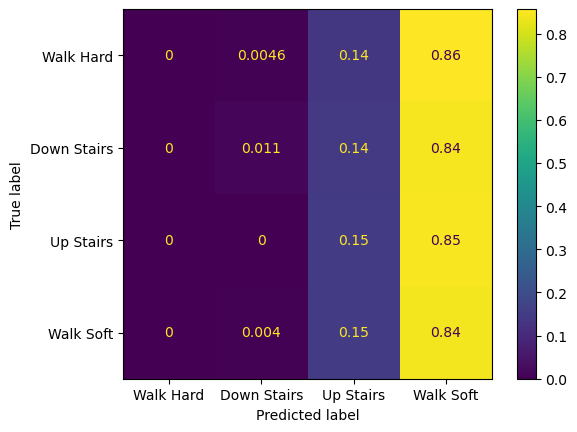

In [23]:
y_train_hat = simple_cnn(train_dataset.tensors[0].to(device)).argmax(1).cpu().numpy()
y_val_hat = simple_cnn(val_dataset.tensors[0].to(device)).argmax(1).cpu().numpy()
summaryPerf(yw_train,y_train_hat,yw_val,y_val_hat)

Accuracy: 0.24591759232887117
 Bal Acc: 0.24591759232887117



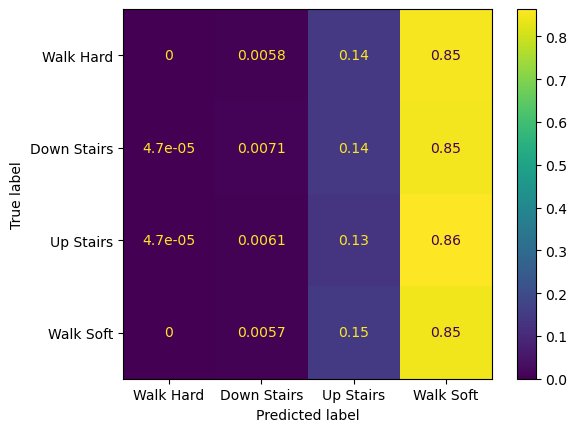

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

def cm(y, y_hat):
    cm = confusion_matrix(y, y_hat, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Walk Hard','Down Stairs','Up Stairs','Walk Soft'])
    disp.plot()
    print(f"Accuracy: {accuracy_score(y,y_hat)}\n Bal Acc: {balanced_accuracy_score(y,y_hat)}\n")
cm(yw_train, y_train_hat)


## Hyperparameter Tuning

In [26]:
import optuna

class CNN_simple(nn.Module): 
    def __init__(self, dropout_p=0.5, kernel1=3, kernel2=3, layer1 = 12,layer2 = 24, hidden_fc = 200):
        super(CNN_simple, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(6, layer1, kernel_size=kernel1, padding="same"),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Conv1d(layer1, layer2, kernel_size=kernel2, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_p), 

            nn.Flatten(),
            nn.Linear(layer2*60, hidden_fc),
            nn.Dropout(p=dropout_p),
            nn.ReLU(),
            nn.Linear(hidden_fc, 4),
        )

    def forward(self, x):
        return self.model(x)

def objective(trial, epochs=90):
    # Hyperparameters
    dropout_p = trial.suggest_float('dropout_p', 0, 0.5)
    kernel1 = trial.suggest_int('kernel1', 3, 5)
    kernel2 = trial.suggest_int('kernel2', 3, 5)
    
    layer2 = trial.suggest_int('layer2', 24, 48)

    weight_decays = trial.suggest_loguniform('weight_decays', 1e-5, 1e-2)

    hidden_fc = trial.suggest_int('hidden_fc', 100, 500)

    weight1 = trial.suggest_float('weight1', 1, 2)

    # For criterion
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    temp_model = CNN_simple(dropout_p=dropout_p, kernel1=kernel1, kernel2=kernel2, layer1=12,
                            layer2=layer2, hidden_fc=hidden_fc)
    temp_model.to(device)

    optimizer_temp = optim.Adam(temp_model.parameters(), lr=learning_rate, weight_decay=weight_decays)
    criterion_temp = nn.CrossEntropyLoss(weight=torch.tensor([weight1, 1, 1, 1]).to(device))
    
    for epoch in range(epochs):
        temp_model.train()
        for inputs, labels in train_dataloader:
            optimizer_temp.zero_grad()
            outputs = temp_model(inputs)
            loss = criterion_temp(outputs, labels)
            loss.backward()
            optimizer_temp.step()

        # validation
        temp_model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for inputs, labels in val_dataloader:
                outputs = temp_model(inputs)
                loss = criterion_temp(outputs, labels)
                val_loss += loss.item()
        trial.report(val_loss, epoch)

    return val_loss        

/home/gathomp3/anaconda3/envs/DiffusionEnv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

# Retrieve best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

In [31]:
def train(temp_model, criterion_temp, optimizer_temp,epochs=90):
    for epoch in range(epochs):
            temp_model.train()
            for inputs, labels in train_dataloader:
                optimizer_temp.zero_grad()
                outputs = temp_model(inputs)
                loss = criterion_temp(outputs, labels)
                loss.backward()
                optimizer_temp.step()
            print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

            # validation
            temp_model.eval()
            with torch.no_grad():
                val_loss = 0.0
                for inputs, labels in val_dataloader:
                    outputs = temp_model(inputs)
                    loss = criterion_temp(outputs, labels)
                    val_loss += loss.item()

                print(f'Epoch: {epoch+1}, Validation Loss: {val_loss}')
    return val_loss

In [40]:
Best_hyperparameters = {'dropout_p': 0.40587686315948546, 'kernel1': 4, 'kernel2': 5, 'layer2': 46, 'weight_decays': 0.00019692647636609424, 'hidden_fc': 201, 'weight1': 1.9504249256178356, 'learning_rate': 4.854207245718259e-05}

cnn_opt = CNN_simple(dropout_p=Best_hyperparameters['dropout_p'], kernel1=Best_hyperparameters['kernel1'], kernel2=Best_hyperparameters['kernel2'], layer1=12,
                            layer2=Best_hyperparameters['layer2'], hidden_fc=Best_hyperparameters['hidden_fc'])
cnn_opt.to(device)

optimizer_opt = optim.Adam(cnn_opt.parameters(), lr=Best_hyperparameters['learning_rate'], weight_decay=Best_hyperparameters['weight_decays'])
criterion_opt = nn.CrossEntropyLoss(weight=torch.tensor([Best_hyperparameters['weight1'], 1, 1, 1]).to(device))

In [41]:
train(cnn_opt, criterion_opt, optimizer_opt, epochs=200)

Epoch: 1, Loss: 0.9366431832313538
Epoch: 1, Validation Loss: 25.82208403944969
Epoch: 2, Loss: 0.7078896760940552
Epoch: 2, Validation Loss: 19.891244515776634
Epoch: 3, Loss: 0.5151459574699402
Epoch: 3, Validation Loss: 19.529102653265
Epoch: 4, Loss: 0.4119729697704315
Epoch: 4, Validation Loss: 20.95808844268322
Epoch: 5, Loss: 0.28998681902885437
Epoch: 5, Validation Loss: 20.758068680763245
Epoch: 6, Loss: 0.41224098205566406
Epoch: 6, Validation Loss: 22.61488652229309
Epoch: 7, Loss: 0.5650665163993835
Epoch: 7, Validation Loss: 23.393919445574284
Epoch: 8, Loss: 0.40184780955314636
Epoch: 8, Validation Loss: 23.558543860912323
Epoch: 9, Loss: 0.29200080037117004
Epoch: 9, Validation Loss: 23.19126655906439
Epoch: 10, Loss: 0.47305285930633545
Epoch: 10, Validation Loss: 23.69223991036415
Epoch: 11, Loss: 0.3702627718448639
Epoch: 11, Validation Loss: 24.077283643186092
Epoch: 12, Loss: 0.37189507484436035
Epoch: 12, Validation Loss: 23.598812229931355
Epoch: 13, Loss: 0.32054

13.2565824277699

Accuracy: 0.987040729136998
 Bal Acc: 0.987040729136998



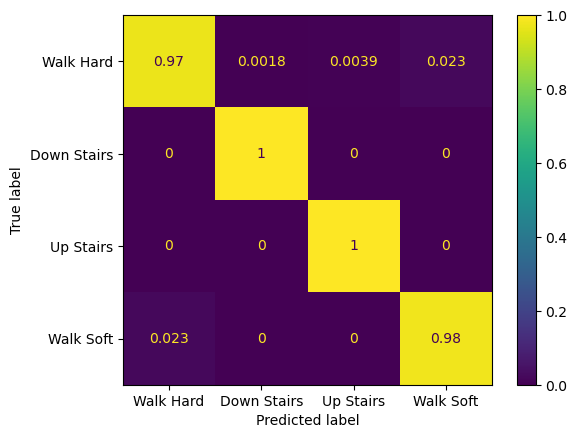

In [42]:
cm(yw_train, cnn_opt(train_dataset.tensors[0].to(device)).argmax(1).cpu().numpy())

Accuracy: 0.8339731285988484
 Bal Acc: 0.843407856301841



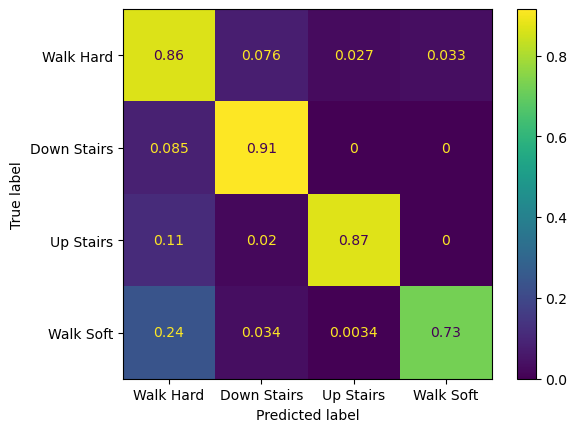

In [43]:
cm(yw_val, cnn_opt(val_dataset.tensors[0].to(device)).argmax(1).cpu().numpy())

## Testing

In [51]:
# Specifying the data directory
dirTest = './GaitData/data/test/'
testIds = [1,2,3,4]

Xw_test1, _, xt_test1, yt_test1 = loadWindows(dirTest,window_size,time_step,[1])
Xw_test2, _, xt_test2, yt_test2 = loadWindows(dirTest,window_size,time_step,[2])
Xw_test3, _, xt_test3, yt_test3 = loadWindows(dirTest,window_size,time_step,[3])
Xw_test4, _, xt_test4, yt_test4 = loadWindows(dirTest,window_size,time_step,[4])


/home/gathomp3/Deep_Learning/NNs/fncs.py:11: RuntimeWarning: invalid value encountered in cast
  yv = y[:,1].astype(int)


Using tuned CNN

In [70]:
Xw_test1 = transform(Xw_test1)
Xw_test2 = transform(Xw_test2)
Xw_test3 = transform(Xw_test3)
Xw_test4 = transform(Xw_test4)

with torch.no_grad():
    y1_hat = cnn_opt.model(Xw_test1)
    y2_hat = cnn_opt.model(Xw_test2)
    y3_hat = cnn_opt.model(Xw_test3)
    y4_hat = cnn_opt.model(Xw_test4)

y1_hat = y1_hat.argmax(1).cpu().numpy()
y2_hat = y2_hat.argmax(1).cpu().numpy()
y3_hat = y3_hat.argmax(1).cpu().numpy()
y4_hat = y4_hat.argmax(1).cpu().numpy()

In [71]:
import pandas as pd

# Read columns to be filled

df1nan = pd.read_csv(dirTest + f'Trial01_y.csv',header=None)
df1nan.columns = ['time','label']
df1nan['time'] = df1nan['time'].round(2)

df2nan = pd.read_csv(dirTest + f'Trial02_y.csv',header=None)
df2nan.columns = ['time','label']
df2nan['time'] = df2nan['time'].round(2)

df3nan = pd.read_csv(dirTest + f'Trial03_y.csv',header=None)
df3nan.columns = ['time','label']
df3nan['time'] = df3nan['time'].round(2)

df4nan = pd.read_csv(dirTest + f'Trial04_y.csv',header=None)
df4nan.columns = ['time','label']
df4nan['time'] = df4nan['time'].round(2)


In [72]:
df4nan

,time,label
0,0.02,NaN
1,0.12,NaN
2,0.22,NaN
3,0.32,NaN
4,0.42,NaN
...,...,...
9493,949.32,NaN
9494,949.42,NaN
9495,949.52,NaN
9496,949.62,NaN


In [73]:
def concat_time_to_labels(ytimes, ylabels):
    df_y = pd.concat([pd.DataFrame(ytimes), pd.DataFrame(ylabels)], axis=1)
    df_y.columns = ['time', 'label']
    return df_y

# Rounding times for outer join later
y1_timelabels = concat_time_to_labels(yt_test1, y1_hat)
y1_timelabels["time"] = y1_timelabels["time"].round(2)

y2_timelabels = concat_time_to_labels(yt_test2, y2_hat)
y2_timelabels["time"] = y2_timelabels["time"].round(2)

y3_timelabels = concat_time_to_labels(yt_test3, y3_hat)
y3_timelabels["time"] = y3_timelabels["time"].round(2)

y4_timelabels = concat_time_to_labels(yt_test4, y4_hat)
y4_timelabels["time"] = y4_timelabels["time"].round(2)

In [75]:
y4_timelabels.tail()

,time,label
942,943.52,0
943,944.52,0
944,945.52,0
945,946.52,0
946,947.52,0


Now, I need to interpolate values between times

In [76]:
df1nan

,time,label
0,0.02,NaN
1,0.12,NaN
2,0.22,NaN
3,0.32,NaN
4,0.42,NaN
...,...,...
8572,857.22,NaN
8573,857.32,NaN
8574,857.42,NaN
8575,857.52,NaN


In [77]:
def interpolate_labels(y_timelabels, dfnan):
    merged_df = pd.merge(y_timelabels, dfnan, on='time', how='outer', suffixes=('_1sec', '_01sec'))

    # Step 2: Forward fill to propagate the last known categorical label
    merged_df['label'] = merged_df['label_1sec'].fillna(method='ffill')

    # Step 3: Backward fill to propagate the first known categorical label
    merged_df['label'] = merged_df['label'].fillna(method='bfill')

    # Drop redundant columns
    merged_df.drop(['label_1sec', 'label_01sec'], axis=1, inplace=True)

    # Final DataFrame with interpolated categorical labels
    final_df = merged_df[['time', 'label']]
    return final_df

In [96]:
y1_final = interpolate_labels(y1_timelabels, df1nan)
y2_final = interpolate_labels(y2_timelabels, df2nan)
y3_final = interpolate_labels(y3_timelabels, df3nan)
y4_final = interpolate_labels(y4_timelabels, df4nan)

/tmp/ipykernel_134224/3767688155.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['label'] = merged_df['label_1sec'].fillna(method='ffill')
/tmp/ipykernel_134224/3767688155.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['label'] = merged_df['label'].fillna(method='bfill')
/tmp/ipykernel_134224/3767688155.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['label'] = merged_df['label_1sec'].fillna(method='ffill')
/tmp/ipykernel_134224/3767688155.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['label'] = merged_df['label'].fillna(method='bfill')
/tmp/ipykernel_134224/3767688155.py:5: Fut

In [97]:
'''
save_path = f"./GaitData/data/saved_data/Trial01_y.csv"
y1_final.to_csv(save_path, index=False, header=False)

save_path = f"./GaitData/data/saved_data/Trial02_y.csv"
y2_final.to_csv(save_path, index=False, header=False)

save_path = f"./GaitData/data/saved_data/Trial03_y.csv"
y3_final.to_csv(save_path, index=False, header=False)

save_path = f"./GaitData/data/saved_data/Trial04_y.csv"
y4_final.to_csv(save_path, index=False, header=False)
'''